<a href="https://colab.research.google.com/github/probml/probml-notebooks/blob/main/notebooks/gp_deep_kernel_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Combine an MLP with a GP 

Modified from
https://tinygp.readthedocs.io/en/latest/tutorials/transforms.html


In [1]:
try:
    import tinygp
except ImportError:
    !pip install -q tinygp

try:
    import flax
except ImportError:
    !pip install -q flax

try:
    import optax
except ImportError:
    !pip install -q optax

from jax.config import config

config.update("jax_enable_x64", True)

     |████████████████████████████████| 207 kB 5.1 MB/s 
     |████████████████████████████████| 126 kB 70.2 MB/s 
     |████████████████████████████████| 65 kB 4.1 MB/s 


# Data

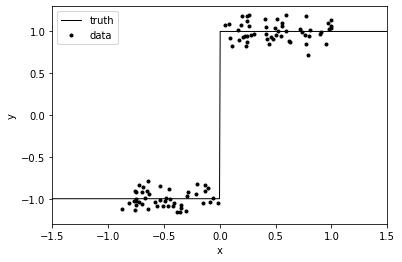

In [8]:
import numpy as np
import matplotlib.pyplot as plt

random = np.random.default_rng(567)

noise = 0.1

x = np.sort(random.uniform(-1, 1, 100))


def true_fn(x):
    return 2 * (x > 0) - 1


y = true_fn(x) + random.normal(0.0, noise, len(x))
t = np.linspace(-1.5, 1.5, 500)


plt.plot(t, true_fn(t), "k", lw=1, label="truth")
plt.plot(x, y, ".k", label="data")
plt.xlim(-1.5, 1.5)
plt.ylim(-1.3, 1.3)
plt.xlabel("x")
plt.ylabel("y")
_ = plt.legend()
plt.savefig("gp-dkl-data.pdf")

# Deep kernel

We transform the (1d) input using an MLP and then pass it to a Matern kernel.

In [14]:
import jax
import optax
import jax.numpy as jnp
import flax.linen as nn
from flax.linen.initializers import zeros
from tinygp import kernels, transforms, GaussianProcess


# Define a small neural network used to non-linearly transform the input data in our model
class Transformer(nn.Module):
    @nn.compact
    def __call__(self, x):
        x = nn.Dense(features=15)(x)
        x = nn.relu(x)
        x = nn.Dense(features=10)(x)
        x = nn.relu(x)
        x = nn.Dense(features=1)(x)
        return x


class GPdeep(nn.Module):
    @nn.compact
    def __call__(self, x, y, t):
        # Set up a typical Matern-3/2 kernel
        log_sigma = self.param("log_sigma", zeros, ())
        log_rho = self.param("log_rho", zeros, ())
        log_jitter = self.param("log_jitter", zeros, ())
        base_kernel = jnp.exp(2 * log_sigma) * kernels.Matern32(jnp.exp(log_rho))

        # Define a custom transform to pass the input coordinates through our `Transformer`
        # network from above
        transform = Transformer()
        kernel = transforms.Transform(transform, base_kernel)

        # Evaluate and return the GP negative log likelihood as usual
        gp = GaussianProcess(kernel, x[:, None], diag=jnp.exp(2 * log_jitter))
        return -gp.condition(y), gp.predict(y, t[:, None], return_var=True)

In [15]:
# Define and train the model
def loss(params):
    return model.apply(params, x, y, t)[0]


model = GPdeep()
params = model.init(jax.random.PRNGKey(1234), x, y, t)
tx = optax.sgd(learning_rate=1e-4)
opt_state = tx.init(params)
loss_grad_fn = jax.jit(jax.value_and_grad(loss))
for i in range(1000):
    loss_val, grads = loss_grad_fn(params)
    updates, opt_state = tx.update(grads, opt_state)
    params = optax.apply_updates(params, updates)

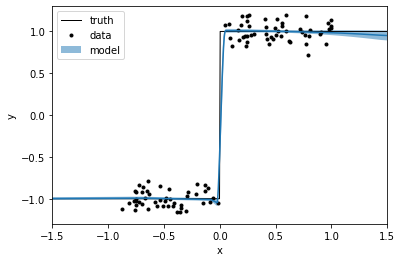

In [16]:
# Plot the results and compare to the true model
plt.figure()
mu, var = model.apply(params, x, y, t)[1]
plt.plot(t, true_fn(t), "k", lw=1, label="truth")
plt.plot(x, y, ".k", label="data")
plt.plot(t, mu)
plt.fill_between(t, mu + np.sqrt(var), mu - np.sqrt(var), alpha=0.5, label="model")
plt.xlim(-1.5, 1.5)
plt.ylim(-1.3, 1.3)
plt.xlabel("x")
plt.ylabel("y")
_ = plt.legend()
plt.savefig("gp-dkl-deep.pdf")

# Shallow kernel

In [17]:
class GPshallow(nn.Module):
    @nn.compact
    def __call__(self, x, y, t):
        # Set up a typical Matern-3/2 kernel
        log_sigma = self.param("log_sigma", zeros, ())
        log_rho = self.param("log_rho", zeros, ())
        log_jitter = self.param("log_jitter", zeros, ())
        base_kernel = jnp.exp(2 * log_sigma) * kernels.Matern32(jnp.exp(log_rho))
        # Evaluate and return the GP negative log likelihood as usual
        gp = GaussianProcess(base_kernel, x[:, None], diag=jnp.exp(2 * log_jitter))
        return -gp.condition(y), gp.predict(y, t[:, None], return_var=True)

In [18]:
model = GPshallow()
params = model.init(jax.random.PRNGKey(1234), x, y, t)
tx = optax.sgd(learning_rate=1e-4)
opt_state = tx.init(params)
loss_grad_fn = jax.jit(jax.value_and_grad(loss))
for i in range(1000):
    loss_val, grads = loss_grad_fn(params)
    updates, opt_state = tx.update(grads, opt_state)
    params = optax.apply_updates(params, updates)

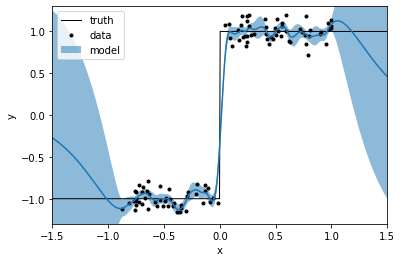

In [19]:
# Plot the results and compare to the true model
plt.figure()
mu, var = model.apply(params, x, y, t)[1]
plt.plot(t, true_fn(t), "k", lw=1, label="truth")
plt.plot(x, y, ".k", label="data")
plt.plot(t, mu)
plt.fill_between(t, mu + np.sqrt(var), mu - np.sqrt(var), alpha=0.5, label="model")
plt.xlim(-1.5, 1.5)
plt.ylim(-1.3, 1.3)
plt.xlabel("x")
plt.ylabel("y")
_ = plt.legend()

plt.savefig("gp-dkl-shallow.pdf")